In [8]:
import pandas as pd
import seaborn as sns
from glob import glob
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
import metaprofile_across_regions as mar

In [9]:
# Files
coverage_files = glob('../../../results/Metaprofiles/UTR3_termini/merged_replicates/*DOWN_*/*_unsmoothed*.tsv') + \
                 glob('../../../results/Metaprofiles/UTR3_termini/merged_replicates/*UP+CONTROL_*/*_unsmoothed*.tsv')

# Sample annotation
annot = pd.read_csv('../../../data/general/SampleAnnotation.csv', index_col=0)

# Save to
outpath = '../../../results/Metaprofiles/UTR3_termini/plots'
os.makedirs(outpath, exist_ok=True)
srcOut = '../../../results/SourceData/raw_saved/'
os.makedirs(srcOut, exist_ok=True)


# Parameters
sw = 20 # Smoothin window

In [10]:
coverage_files

['../../../results/Metaprofiles/UTR3_termini/merged_replicates/UTR3ends_DOWN_up500_down0_cond-S200WT_FCL/coverage_unsmoothed_norm-by_reg.tsv',
 '../../../results/Metaprofiles/UTR3_termini/merged_replicates/UTR3ends_DOWN_up500_down0_cond-S200WT_FCL/coverage_unsmoothed_norm-libsize.tsv',
 '../../../results/Metaprofiles/UTR3_termini/merged_replicates/UTR3ends_DOWN_up500_down0_cond-S200WT_2iL/coverage_unsmoothed_norm-by_reg.tsv',
 '../../../results/Metaprofiles/UTR3_termini/merged_replicates/UTR3ends_DOWN_up500_down0_cond-S200WT_2iL/coverage_unsmoothed_norm-libsize.tsv',
 '../../../results/Metaprofiles/UTR3_termini/merged_replicates/UTR3ends_DOWN_up500_down0_cond-S200A_FCL/coverage_unsmoothed_norm-by_reg.tsv',
 '../../../results/Metaprofiles/UTR3_termini/merged_replicates/UTR3ends_DOWN_up500_down0_cond-S200A_FCL/coverage_unsmoothed_norm-libsize.tsv',
 '../../../results/Metaprofiles/UTR3_termini/merged_replicates/UTR3ends_DOWN_up500_down0_cond-KO_FCL/coverage_unsmoothed_norm-by_reg.tsv',
 '

In [11]:
def smoothDf(df, sw):
    cols = [c for c in df.columns.tolist() if c in ['ciMax', 'ciMin', 'mean']]
    df[cols] = df[cols].rolling(sw, center=True,  win_type='triang', axis=0).mean()\
                    .fillna(axis=0, method='ffill')\
                    .fillna(axis=0, method='bfill')
    return df

In [12]:
# Combine into one table
dfList = []
for f in coverage_files:
    df = pd.read_csv(f, sep='\t')
    df['Group'] = f.split('/')[-2].split('_')[1]
    df['Condition'] = f.split('/')[-2].split('cond-')[-1]
    df['Norm'] = f.split('/')[-1].split('norm-')[-1].split('.')[0]
    dfList.append(df)
dfCombined = pd.concat(dfList)

In [13]:
# Smooth with a desired window
dfCombined = dfCombined.groupby(['Sample', 'Condition', 'Norm', 'Group']).apply(smoothDf, sw=sw)

In [14]:
# Annotate samples
dfCombined = dfCombined.merge(annot, on=['Sample', 'Condition'], how='left')
dfCombined.head()

,mean,ciMin,ciMax,Sample,Position,Group,Condition,Norm,Protein,Experiment
0,0.002777,0.001995,0.003558,KO_C1_Crick_merged.bed.gz,-500,DOWN,KO_FCL,by_reg,PABPC1,Crick - merged
1,0.002172,0.001823,0.002520,KO_C1_Crick_merged.bed.gz,-500,UP+CONTROL,KO_FCL,by_reg,PABPC1,Crick - merged
2,0.076670,0.051438,0.101902,KO_C1_Crick_merged.bed.gz,-500,DOWN,KO_FCL,libsize,PABPC1,Crick - merged
3,0.046142,0.029810,0.062475,KO_C1_Crick_merged.bed.gz,-500,UP+CONTROL,KO_FCL,libsize,PABPC1,Crick - merged
4,0.001871,0.000796,0.002946,LIN28A-S200A_ESC_LIF-CHIR-FGF0220626_MM_1_merg...,-500,DOWN,S200A_FCL,by_reg,LIN28A,FLAG-IP LIN28A - merged


In [15]:
# Save Source Data files
dfSrc = dfCombined.copy()
# Drop unnecessary columns
dfSrc = dfSrc.drop(['Experiment'], axis=1)
# Rename columns (in these files
dfSrc = dfSrc.rename(columns={'mean': 'Mean normalised signal at position', 'ciMin': '95% CI min', 'ciMax': '95% CI max', 'Position': 'Position (nt)', 'Group': 'Gene Group'})
# Save one fource file for each Protein-normalization combination
for (prot, norm), df in dfSrc.groupby(['Protein', 'Norm']):
    # Drop Norm column and save
    df.drop('Norm', axis=1).to_csv(f'{srcOut}/MetaprofileTable_{prot}_Normalised-{norm}_UtrTermini.csv', index=False)

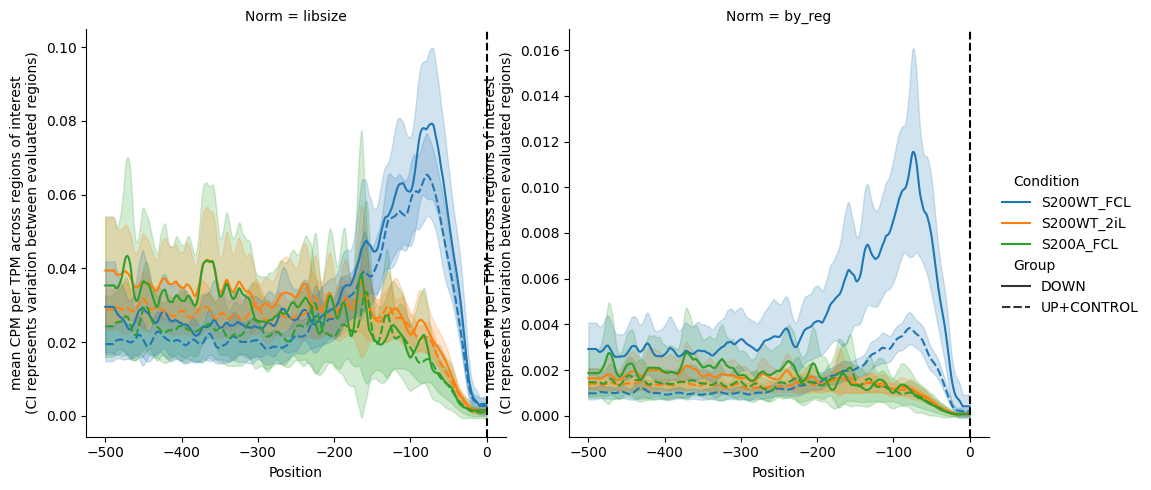

In [16]:
# Plot
# Plot LIN28A aroud PAS in UP / DOWN / CTRL -  libnorm and expr norm side by side
dfPlot = dfCombined.loc[(dfCombined.Protein == 'LIN28A') & (dfCombined.Group!='naive')]

hue_order = ['S200WT_FCL', 'S200WT_2iL', 'S200A_FCL']
colorMap = {sample: sns.color_palette('tab10', len(hue_order))[i] for i, sample in enumerate(hue_order)}

g = sns.relplot(
    data=dfPlot, x='Position', y='mean', hue='Condition',
    style='Group', kind='line', col='Norm', facet_kws={'sharey': False, 'sharex': True},
    style_order=['DOWN', 'UP+CONTROL'], hue_order=['S200WT_FCL', 'S200WT_2iL', 'S200A_FCL'],
    col_order=['libsize', 'by_reg'], palette=colorMap
    )

for idx, ax in g.axes_dict.items():
    df = dfPlot.loc[dfPlot['Norm'] == idx]
    ax.axvline(0, color='black', ls='dashed')
    for line_ids, dft in df.groupby(['Condition', 'Group']):
        ax.fill_between(dft.Position, dft.ciMax, dft.ciMin, alpha=0.2, color=colorMap[line_ids[0]])
        if idx[-1] == 'libsize':
            ax.set_ylabel('mean CPM across regions of interest\n(CI represents variation between evaluated regions)')
        else:
            ax.set_ylabel('mean CPM per TPM across regions of interest\n(CI represents variation between evaluated regions)')
g.fig.savefig(f'{outpath}/LIN28A_metaprofiles.pdf', bbox_inches='tight')

('PABPC1', 'libsize')
('PABPC1', 'by_reg')
('PABPC4', 'libsize')
('PABPC4', 'by_reg')


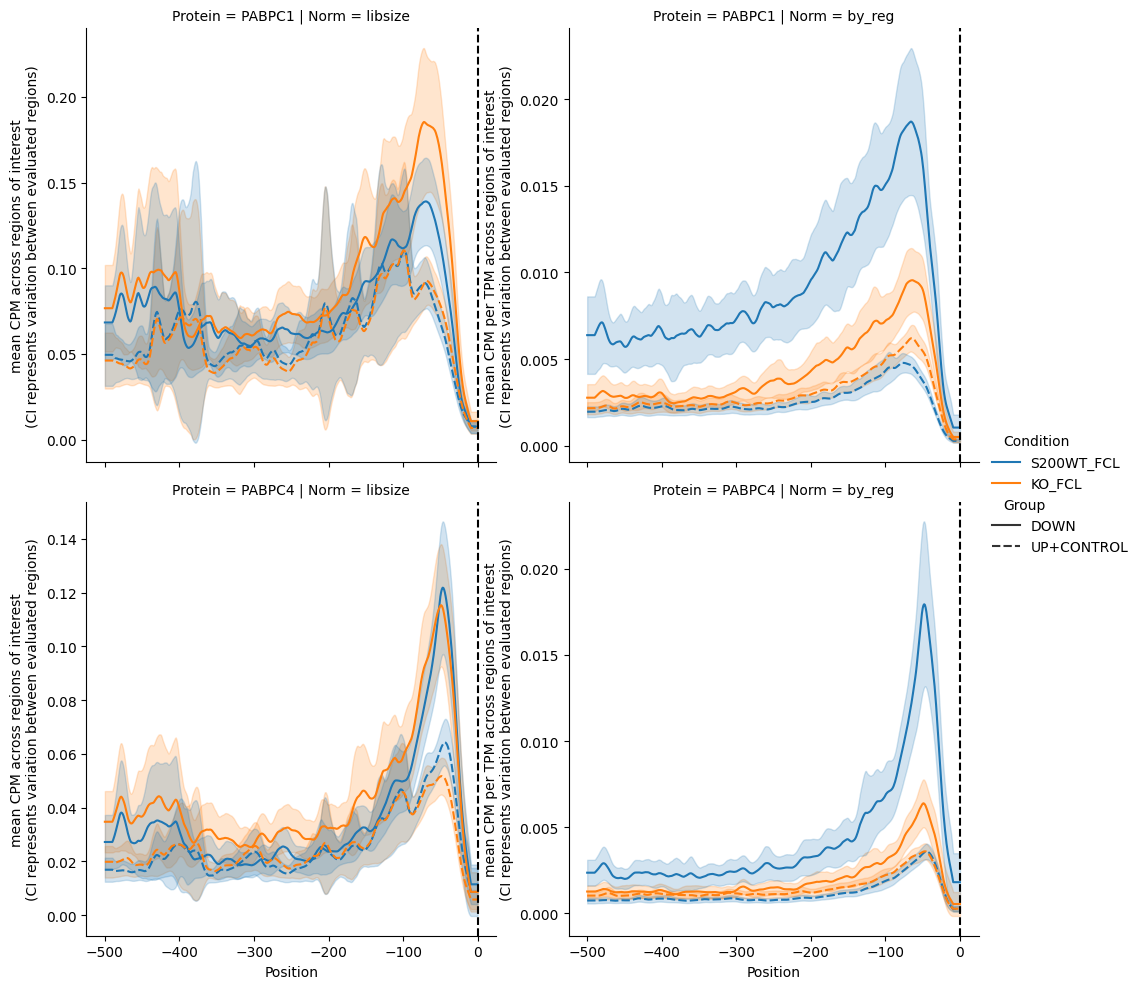

In [17]:
# # Plot PABPC1 and C4 aroud PAS in UP / DOWN / CTRL -  libnorm and expr norm side by side
dfPlot = dfCombined.loc[(dfCombined.Protein != 'LIN28A') & (dfCombined.Group!='naive')]

hue_order = ['S200WT_FCL', 'KO_FCL']
colorMap = {sample: sns.color_palette('tab10', len(hue_order))[i] for i, sample in enumerate(hue_order)}

g = sns.relplot(
    data=dfPlot, x='Position', y='mean', hue='Condition',
    style='Group', kind='line', col='Norm', row='Protein', facet_kws={'sharey': False, 'sharex': True},
    style_order=['DOWN', 'UP+CONTROL'], hue_order=hue_order, col_order=['libsize', 'by_reg'], palette=colorMap,
    )

for idx, ax in g.axes_dict.items():
    print(idx)
    df = dfPlot.loc[(dfPlot['Norm'] == idx[1]) & (dfPlot['Protein'] == idx[0])]
    ax.axvline(0, color='black', ls='dashed')
    for line_ids, dft in df.groupby(['Condition', 'Group']):
        ax.fill_between(dft.Position, dft.ciMax, dft.ciMin, alpha=0.2, color=colorMap[line_ids[0]])
        if idx[-1] == 'libsize':
            ax.set_ylabel('mean CPM across regions of interest\n(CI represents variation between evaluated regions)')
        else:
            ax.set_ylabel('mean CPM per TPM across regions of interest\n(CI represents variation between evaluated regions)')
g.fig.savefig(f'{outpath}/PABP_metaprofiles.pdf', bbox_inches='tight')